# G-Mode KPFM with Fast Free Force Recovery (F3R)
#### Liam Collins, Anugrah Saxena, and Chris R. Smith
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>

### References:
This Jupyter notebook uses [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) to analyze Band Excitation data. We request you to reference the following papers if you use this notebook for your research:

* [Arxiv paper](https://arxiv.org/abs/1903.09515) titled "*USID and Pycroscopy - Open frameworks for storing and analyzing spectroscopic and imaging data*" in your publications.  
* [ACS Nano paper](https://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114) titled "*Breaking the Time Barrier in Kelvin Probe Force Microscopy: Fast Free Force Reconstruction Using the G-Mode Platform*"

### Methodology:
This notebook will allow  fast KPFM by recovery of the electrostatic foce directly from the photodetector response. Information on the procedure can be found in Collins et al. ([DOI: 10.1021/acsnano.7b02114](http://pubs.acs.org/doi/abs/10.1021/acsnano.7b02114)) In this notebook the following procedured are performed.

#### (1) Models the Cantilever Transfer Function (H(w)) 
**(1a)** Translates Tune file to H5 <br>
**(1b)** Fits Cantilever resonances to SHO Model <br>
**(1c)** Constructs the effective cantilever transfer function (H(w)) from SHO fits of the tune. <br>
#### (2)Load, Translate and Denoize the G-KPFM data 
**(2a)** Loads and translates the .mat file containing the image data to .H5 file format. <br>
**(2b)** Fourier Filters data. <br>
**(2bii)** Checks Force Recovery for 1 pixel...here you need to find the phase offset used in 3. <br>
**(2c- optional)** PCA Denoizing.<br>   
        
#### (3) Fast Free Force Reconstruction   
**(3a)** Divides filtered displacement Y(w) by the effective transfer function (H(w)). <br>
<font color=red>This takes some time, can we parallelize it?. One option would be to incorperate it into the FFT filtering **step (2b** <br></font>
**(3b)** iFFT the response above a user defined noise floor to recovery Force in time domain.<br>
**(3c)** Phase correction (from step 2biii).<br>
<font color=red>I havent settled on the best way to find the phase shift required, but I see ye are working towards incorperating a phase shift into the filtering <br></font>

#### (4) Data Analysis
**(4a)** Parabolic fitting to extract CPD.<br>
<font color=red>Needs to be parallilized and output written to H5 file correctly. <br></font>

#### (5) Data Visualization
**(5a)** Visualization and clustering of fitting parameters and CPD.<br>
<font color=red>GIF movies and Kmeans clustering will be added. <br></font>

--------------

This is a Jupyter Notebook - it contains text and executable code `cells`. To learn more about how to use it, please see [this video](https://www.youtube.com/watch?v=jZ952vChhuI). Please see the image below for some basic tips on using this notebook.

If you have any questions or need help running this notebook, please get in touch with your host if you are a users at the Center for Nanophase Materials Science (CNMS) or our [google group](https://groups.google.com/forum/#!forum/pycroscopy).

![notebook_rules.png](https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/jupyter_notebooks/notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

#### Change the filepath below, used for storing images

In [1]:

output_filepath = r"E:\Dropbox (ORNL)\Paper Drafts\GMode KPFM photovoltaics\data\IMageA_3V_3Vac_0022 - Copy - Copy"

################################################################
### here you can decide what analysis to do // or what previous results to load
################################################################

save_figure = True 
load_tune_results = True # Set this to true if you want to go fetch already analyzed data
load_image_results = True # Set this to true if you want to go fetch already analyzed data
Filter_data= False   # Set this to true if you want to filter data
PCA_clean=False   # Set this to true if you want to do PCA filtering
Do_PCA2=False 
DO_F3R = False  # Set this to true if you want to do F3R recovery or just load data from file
do_para_fit= False  # Set this to true if you want to do parabolic fitting
do_PCA_CPD= False  # Set this to true if you want to do PCA of CPD results

#Number of cores available for parallel processing
num_cores=10



#If you have already fit the data (i.e. load_tune_results or load_image_results are true) then you should provide links to tune and image files below

if load_tune_results:
    #Tune data
    h5tune_file_path = r"E:\Dropbox (ORNL)\Paper Drafts\GMode KPFM photovoltaics\data\Tune_Edrive_2Mhz_6V_withdrive100nm_0019\Tune_Edrive_2Mhz_6V_withdrive100nm_0019.h5"


if load_image_results:
    #Image data
    h5image_file_path = r"E:\Dropbox (ORNL)\Paper Drafts\GMode KPFM photovoltaics\data\IMageA_3V_3Vac_0022 - Copy - Copy\IMageA_3V_3Vac_0022 - Copy - Copy.h5"
   



## Installing required package

If you run the cell below it will update your pycrosocpy to the latest version from repository as well as installing updates to some important functions. Note we use a rolled back version of joblib

In [2]:
# If not sure then uncomment run this at least once
####################################################################
# Make sure needed packages are installed and up-to-date
######################################################

#import sys
#!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py
#!{sys.executable} -m pip install -U --no-deps pycroscopy
# Current joblib release has some issues, so install from the github repository.
#!{sys.executable} -m pip install --ignore-installed -U git+https://github.com/joblib/joblib.git@14784b711f2e777e87c857c5a0e8fbd9d5849936

## Configure Notebook

In the cell below we import important packages required below

In [3]:
# set up notebook to show plots within the notebook
%matplotlib inline
%precision %.4g

# Import necessary libraries:

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy.io import loadmat

# General utilities:
import os
import sys
from scipy.signal import correlate
from warnings import warn

# Interactive Value picker
import ipywidgets as widgets

# Computation:
import numpy as np
import numpy.polynomial.polynomial as npPoly

# Parallel computation library:
try:
    import joblib
except ImportError:
    warn('joblib not found.  Will install with pip.')
    import pip
    pip.main(['install', 'joblib'])
import joblib

import h5py

from functools import partial

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

#sys.path.insert(0,r'C:\Users\lz1\Documents\PyWorkspace\pycroscopy\pycroscopy-latest')
# Finally, pycroscopy itself
import pycroscopy as px

from pycroscopy.core.viz.plot_utils import set_tick_font_size, plot_curves, plot_map_stack

# Define Layouts for Widgets
lbl_layout=dict(
    width='15%'
)
widget_layout=dict(
    width='15%',margin='0px 0px 5px 12px'
)
button_layout=dict(
    width='15%',margin='0px 0px 0px 5px'
)

# IPython.OutputArea.prototype._should_scroll = function(lines) (
#     return false;
# )

C:\Users\lz1\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Define Cantilever Parameters

Here you should input the calibrated parameters of the tip from your experiment. In particular the lever sensitivity (m/V) and Spring Constant (N/m) which will be used to convert signals to displacement and force respectively.

In [4]:
# 'k', 'invols', 'Thermal_Q', 'Thermal_resonance'
cantl_parms = dict()
cantl_parms['k']=70 # N/M
cantl_parms['invols'] = 2e-9 #m/V


print(cantl_parms)

num_cores = 2
max_mem_mb = 2*1048
keep_vars = dir()

{'k': 70, 'invols': 2e-09}



## Step 1.) Model the Cantilever Transfer Function

First we need to read in the tune file for the cantilever your used to perform your measurment with. This tune show capture the "free" SHO parameters of the cantilever. If you have previously translated this data you can change the data type in the bottom right corner to .h5, others click the parms file.txt

#### Step 1a. Translates Tune file to HF5 format


/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
  ├ Channel_001
    -----------
    ├ Raw_Data
  ├ Position_Indices
  ├ Position_Values
  ├ Spectroscopic_Indices
  ├ Spectroscopic_Values
  ├ Tune_Function_000
    -----------------
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ Tune_Data


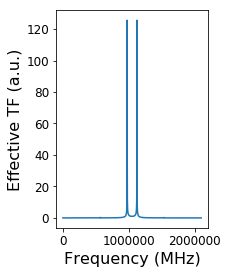

In [5]:

if not load_tune_results:
   input_file_path = px.core.io_utils.file_dialog(file_filter='Parameters for raw G-Line data (*.dat);; \
                                        Translated file (*.h5)', caption='Select translated .h5 file or raw experiment data')


   tune_path, _ = os.path.split(input_file_path)
   tune_file_base_name=os.path.basename(tune_path)

   if input_file_path.endswith('.h5'):
     h5_path_tuned = input_file_path
   else:
     print('Translating raw data to h5. Please wait')
     tran=px.io.translators.GTuneTranslator()
     h5_path_tuned=tran.translate(input_file_path)
        

    ##############################################################
    ##Step 1b. Extract the Resonance Modes Considered in the Force Reconstruction
    ##############################################################

    #define number of eigenmodes to consider
   num_bandsVal=2

    #define bands (center frequency +/- bandwith)
   MB0_w1 = 70E3 - 20E3
   MB0_w2 = 70E3 + 20E3

   MB1_w1 = 460E3 - 20E3
   MB1_w2 = 460E3 + 20E3

   MB1_amp = 30E-9
   MB2_amp = 1E-9

   MB_parm_vec = np.array([MB1_amp,MB0_w1,MB0_w2,MB1_amp,MB1_w1,MB1_w2])
   MB_parm_vec.resize(2,3)
   band_edge_mat = MB_parm_vec[:,1:3]

   h5_file = h5py.File(h5_path_tuned, 'r+')

   h5_tune_resp = px.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]
   h5_tune = px.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]

   samp_rate = (px.hdf_utils.get_attr(h5_tune.parent.parent, 'IO_rate_[Hz]'))
   num_rows=h5_tune.pos_dim_sizes[0]
   N_points_per_line=h5_tune.spec_dim_sizes[0]
   N_points_per_pixel=N_points_per_line / num_rows
   w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)
   dt = 1/samp_rate
   df = 1/dt

    # Response
   A_pd = np.mean(h5_tune_resp, axis=0)
   yt0_tune = A_pd - np.mean(A_pd)
   Yt0_tune = np.fft.fftshift(np.fft.fft(yt0_tune,N_points_per_line)*dt)

    # Excitation
   h5_spec_vals = px.hdf_utils.get_auxiliary_datasets(h5_tune, aux_dset_name='Spectroscopic_Values')[0]
   BE_pd = h5_spec_vals[0, :]

   f0 = BE_pd - np.mean(BE_pd)
   F0 = np.fft.fftshift(np.fft.fft(f0,N_points_per_line)*dt)
   excited_bin_ind = np.where(np.abs(F0)>1e-3)

   TF_vec = Yt0_tune/F0

   plt.figure(2)
   plt.subplot(2,1,1)
   plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.abs(TF_vec[excited_bin_ind]))
   plt.tick_params(labelsize=14)
   plt.xlabel('Frequency (MHz)',fontsize=16)
   plt.ylabel('Amplitude (a.u.)',fontsize=16)
   plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
   plt.subplot(2,1,2)
   plt.semilogy(np.abs(w_vec2[excited_bin_ind])*1E-6,np.angle(TF_vec[excited_bin_ind]))
   plt.tick_params(labelsize=14)
    #plt.ylim([1E-4, 1E+1]) # Beth added this line
    #plt.xlim([0,1]) # Beth added this line
   plt.xlabel('Frequency (MHz)',fontsize=16)
   plt.ylabel('Phase (Rad)',fontsize=16)
   plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


    ##############################################################
    ##Step 1c. Construct an effective Transfer function (TF_Norm) from SHO fits
    ##############################################################

   TunePhase = -np.pi
   num_bands = band_edge_mat.shape[0]
   coef_mat = np.zeros((num_bands,4))
   coef_guess_vec = np.zeros((4))
   TF_fit_vec = np.zeros((w_vec2.shape))
   TFb_vec = TF_vec[excited_bin_ind]
   wb = w_vec2[excited_bin_ind]


   for k1 in range(num_bandsVal):

        # locate the fitting region
       w1 = band_edge_mat[k1][0]
       w2 = band_edge_mat[k1][1]
       bin_ind1 = np.where(np.abs(w1-wb) == np.min(np.abs(w1-wb)))[0][0]
       bin_ind2 = np.where(np.abs(w2-wb) == np.min(np.abs(w2-wb)))[0][0]
       response_vec = TFb_vec[bin_ind1:bin_ind2+1].T
       wbb = wb[bin_ind1:bin_ind2+1].T/1E+6

       if k1 == 0:
            Q_guess = 120
            #Q_guess = 50

       elif k1 == 1:
           Q_guess = 500
           # Q_guess = 150
       else:
           Q_guess = 700
          #  Q_guess = 75

       response_mat = np.array([np.real(response_vec), np.imag(response_vec)]).T
       A_max_ind = np.argmax(np.abs(response_vec))
       A_max = response_vec[A_max_ind]
       A_guess = A_max/Q_guess
       wo_guess = wbb[A_max_ind]

       if k1 == 0:
           phi_guess = TunePhase

       coef_guess_vec[0] = np.real(A_guess)
       coef_guess_vec[1] = wo_guess
       coef_guess_vec[2] = Q_guess
       coef_guess_vec[3] = phi_guess

       LL_vec = [0,w1/1E+6,1,np.pi] # lower limit
       UL_vec = [float("inf"),w2/1E+6,10000,-np.pi] # upper limit

       coef_vec = px.analysis.utils.be_sho.SHOestimateGuess(response_vec,wbb,10)

       response_guess_vec = px.analysis.utils.be_sho.SHOfunc(coef_guess_vec,wbb)
       response_fit_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,wbb)

       coef_vec[1] = coef_vec[1]*1E6
       coef_mat[k1,:] = coef_vec

       response_fit_full_vec = px.analysis.utils.be_sho.SHOfunc(coef_vec,w_vec2)

       TF_fit_vec = TF_fit_vec + response_fit_full_vec # check for length and dimension


       plt.figure(10, figsize=(12, 4))
       plt.subplot(1, 4, k1+1)
       plt.plot(wbb,np.abs(response_vec),'.-')
       plt.plot(wbb,np.abs(response_guess_vec),c='g')
       plt.plot(wbb,np.abs(response_fit_vec),c='r')
       plt.tick_params(labelsize=12)
       plt.xlabel('Frequency (MHz)', fontsize=16)
       plt.ylabel('Amplitude (nm)', fontsize=16)
       plt.subplot(1, 4, (k1+1)+2)
       plt.plot(wbb,np.angle(response_vec),'.-')
       plt.plot(wbb,np.angle(response_guess_vec),c='g')
       plt.plot(wbb,np.angle(response_fit_vec),c='r')
       plt.tick_params(labelsize=12)
       plt.xlabel('Frequency (MHz)', fontsize=16)
       plt.ylabel('Phase (Rad)', fontsize=16)
       plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

   if save_figure == True:
       plt.savefig(output_filepath+'\SHOFitting.tif', format='tiff', transparent=True)

    ##############################################################
    ##Step 1d. write and save data to HDF5
    ##############################################################

   Q = coef_mat[0,2]
   TF_norm = ((TF_fit_vec- np.min(np.abs(TF_fit_vec)))/np.max(np.abs(TF_fit_vec))- np.min(np.abs(TF_fit_vec)))*Q


   tf_grp = px.hdf_utils.create_indexed_group(h5_tune.parent.parent, 'Tune_Function')
   tf_pos_dim = px.hdf_utils.Dimension('Single Step', 'a.u.', 1)
   tf_spec_dim = px.hdf_utils.Dimension('Frequency', 'MHz', w_vec2)
   h5_tf = px.hdf_utils.write_main_dataset(tf_grp, TF_norm.reshape(1, -1), 'Tune_Data', 
                                               'Response', 'a.u.',
                                               tf_pos_dim, tf_spec_dim)

   h5_file.close()


if load_tune_results:
   h5_file = h5py.File(h5tune_file_path, 'r+')
   px.hdf_utils.print_tree(h5_file)
   
   h5_tune = px.hdf_utils.find_dataset(h5_file, 'Raw_Data')[-1]
   TFnorm = px.hdf_utils.find_dataset(h5_file, 'Tune_Data')[0]
   TF_norm = np.mean(TFnorm, axis=0)
   samp_rate = (px.hdf_utils.get_attr(h5_tune.parent.parent, 'IO_rate_[Hz]'))
   num_rows=h5_tune.pos_dim_sizes[0]
   N_points_per_line=h5_tune.spec_dim_sizes[0]
   N_points_per_pixel=N_points_per_line / num_rows
   w_vec2 = np.linspace(-0.5 * samp_rate, 0.5 * samp_rate - 1.0*samp_rate / N_points_per_line, N_points_per_line)
    

   plt.subplot(1, 2, 1)
   plt.plot(np.abs(TF_norm))
   plt.tick_params(labelsize=12)
   plt.xlabel('Frequency (MHz)', fontsize=16)
   plt.ylabel('Effective TF (a.u.)', fontsize=16)
 
 

# Step (2) Load, Translate and Denoize the G-KPFM data 

#### Step (2a) Load and Translates image file to .H5 file format.

In [6]:
img_length = 10e-6
img_height = 5e-6

In [7]:
if not load_image_results:
    input_file_path = px.io_utils.file_dialog(caption='Select translated .h5 file or raw experiment data',
                                            file_filter='Parameters for raw G-Line data (*.dat);; \
                                            Translated file (*.h5)')
    folder_path, _ = os.path.split(input_file_path)

    if input_file_path.endswith('.h5'):
        print('Working on:\n' + h5_path)   
        h5_path = input_file_path


    else:
        print('Translating raw data to h5. Please wait')
        tran = px.io.translators.GLineTranslator()
        h5_path = tran.translate(input_file_path)
 



#### Extract some relevant parameters

In [8]:
if not load_image_results:
    hdf = h5py.File(h5_path, 'r+')

    h5_main = px.hdf_utils.find_dataset(hdf,'Raw_Data')[0]
    (basename, parm_paths, data_paths) = px.io.translators.GLineTranslator._parse_file_path(input_file_path)
    
elif load_image_results:
    
    hdf = h5py.File(h5image_file_path, 'r+')

    h5_main = px.hdf_utils.find_dataset(hdf,'Raw_Data')[0]
    
    (basename, parm_paths, data_paths) = px.io.translators.GLineTranslator._parse_file_path(h5image_file_path)
    px.hdf_utils.print_tree(hdf)

matread = loadmat(parm_paths['parm_mat'], variable_names=['BE_wave_AO_0', 'BE_wave_AO_1', 'total_cols', 'total_rows'])
pulse_wave = np.float32(np.squeeze(matread['BE_wave_AO_1'])) 

h5_pos_vals=h5_main.h5_spec_vals 
h5_pos_inds=h5_main.h5_spec_inds
h5_spec_vals = h5_main.h5_spec_vals 
h5_spec_inds = h5_main.h5_spec_inds 

samp_rate = (px.hdf_utils.get_attr(h5_main.parent.parent, 'IO_rate_[Hz]'))

num_rows=h5_main.pos_dim_sizes[0]
N_points_per_line=h5_main.spec_dim_sizes[0]
N_points_per_pixel=N_points_per_line / num_rows

# General parameters
parms_dict = h5_main.parent.parent.attrs
samp_rate = parms_dict['IO_rate_[Hz]']
ex_freq = parms_dict['BE_center_frequency_[Hz]']
num_rows = parms_dict['grid_num_rows']
num_cols = parms_dict['grid_num_cols']

num_pts = h5_main.shape[1]
pnts_per_pix=int(num_pts/num_cols)


# Adding image size to the parameters
parms_dict['FastScanSize'] = img_length
parms_dict['SlowScanSize'] = img_height

N_points = parms_dict['num_bins']
N_points_per_pixel = parms_dict['num_bins']
time_per_osc = (1/parms_dict['BE_center_frequency_[Hz]'])
IO_rate = parms_dict['IO_rate_[Hz]']     #sampling_rate
parms_dict['sampling_rate'] = IO_rate
pnts_per_period = IO_rate * time_per_osc #points per oscillation period
pxl_time = N_points_per_pixel/IO_rate    #seconds per pixel
num_periods = int(pxl_time/time_per_osc) #total # of periods per pixel, should be an integer

# Excitation waveform for a single pixel
#pixel_ex_wfm = h5_spec_vals[0, :int(h5_spec_vals.shape[1]/num_cols)]

pixel_ex_wfm = np.float32(np.squeeze(matread['BE_wave_AO_0'])) 

# Excitation waveform for a single line / row of data
excit_wfm = h5_spec_vals.value

# Preparing the frequency axis:
w_vec = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/num_pts, num_pts)
w_vec_pix = 1E-3*np.linspace(-0.5*samp_rate, 0.5*samp_rate - samp_rate/pnts_per_pix, pnts_per_pix)

# Preparing the time axis:
t_vec_line = 1E3*np.linspace(0, num_pts/samp_rate, num_pts)
t_vec_pix = 1E3*np.linspace(0, pnts_per_pix/samp_rate, pnts_per_pix)

# Dimension objects
rows_vals = np.linspace(0, img_height, num_rows)
cols_vals = np.linspace(0, img_length, num_cols)
time_vals = t_vec_pix

# Correctly adds the ancillary datasets
pos_dims = [px.write_utils.Dimension('Cols', 'm', cols_vals),
            px.write_utils.Dimension('Rows', 'm', rows_vals)]
spec_dims = [px.write_utils.Dimension('Time', 's', time_vals)]

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ Rebuilt_Data_000
        ----------------
        ├ Rebuilt_Data
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
  ├ Channel_000
    -----------
    ├ F3R_Results_000
      ---------------
      ├ F3R_data
      ├ F3R_data-Reshape_000
        --------------------
        ├ Position_Indices
        ├ Position_Values
        ├ Reshaped_Data
        ├ Reshaped_Data-SVD_000
          ---------------------
          ├ Position_Indices
          ├ Position_Values
          ├ S
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
          ├ U
          ├ V
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Position_Indices
      ├ Position_Values
      ├ Spe

#### Step 2b Fourier Filter data.

--Step ignored if loading previous results

** Here you can play with Noise tolerance **

In [9]:
 # Test filter on a single line:
 row_ind = 9
    
if Filter_data:
    # Set Filter parameters here:
    num_spectral_pts = h5_main.shape[1]
    
    ##############################################################################################################################
    #### Here you can play with Low Pass Filter
    ################################################################################################################
    lpf = px.processing.fft.LowPassFilter(num_pts, samp_rate, 180E+3) # low pass filter
    
     ##############################################################################################################################
    #### Here you can play with Noise band filter
    ################################################################################################################
    nbf = px.processing.fft.NoiseBandFilter(num_pts, samp_rate, [125E+3, 50E+3, 5E+3, 100E+3], [2E+3, 1E+3, 20E+3, 5E+3 ])
    
    ################################################################################################################################
    #### Here you can play with Noise Noise tolerance
    ################################################################################################################
    
    noise_tolerance = 1000E-9
        
    freq_filts = [lpf, nbf]
   
   
  
    excit_wfm = h5_spec_vals[-1]

    filt_line, fig_filt, axes_filt = px.processing.gmode_utils.test_filter(h5_main[row_ind], 
                                                                           frequency_filters=freq_filts, 
                                                                           noise_threshold=noise_tolerance, 
                                                                           show_plots=True)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


    if save_figure == True:
        fig=fig_filt

        fig.savefig(output_filepath+'\FFTFiltering.tif', format='tiff')


        filt_row = filt_line.reshape(-1, pixel_ex_wfm.size)

        fig_loops, axes_loops = plot_curves(pixel_ex_wfm, filt_row, line_colors=['r'], x_label='Excitation',
                                                    y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                    title='test',use_rainbow_plots=True)  
    #############################################################################################################
    ####  Try force conversion on random row
    ###############################################################################################################
    
    
    ################################################################################################################
    #### Here you should adjust phas to reduce hysteresis in the parabola
    ################################################################################################################
    
    ph=-0.35#original
   

    ################################################################################################################
    #### Here you set the Noise threshold for the force recovery bins
    ################################################################################################################
    
    Noiselimit = 100;

    # Try Force Conversion on Filtered data
    G=np.zeros(w_vec.size,dtype=complex)

    G_wPhase=np.zeros(w_vec.size,dtype=complex)


    signal_ind_vec=np.arange(w_vec.size)
    ind_drive = (np.abs(w_vec*1e3-ex_freq)).argmin()
    test1=filt_line-np.mean(filt_line)
    test1=np.fft.fftshift(np.fft.fft(test1))
   # signal_kill = np.where(np.abs(test1)<Noiselimit)
    #signal_ind_vec=np.delete(signal_ind_vec,signal_kill)
    signal_keep = np.argwhere(np.abs(test1)>=Noiselimit).squeeze()

    test=(test1)*np.exp(-1j*w_vec*1e3 /(w_vec[ind_drive]*1e3)*ph)

    G_wPhase[signal_keep]=test[signal_keep]
    G_wPhase=(G_wPhase/TF_norm)

    G_wPhase_time=np.real(np.fft.ifft(np.fft.ifftshift(G_wPhase)))

    #G[signal_ind_vec]=test1[signal_ind_vec]
    G[signal_keep]=test1[signal_keep]
    G=(G/TF_norm)
    G_time=np.real(np.fft.ifft(np.fft.ifftshift(G)))
                                              
    FRaw_resp = np.fft.fftshift(np.fft.fft(h5_main[row_ind]))

    fig, ax = plt.subplots(figsize=(12, 7))
    plt.semilogy(w_vec, (np.abs(FRaw_resp)), label='Response')
    plt.semilogy(w_vec[signal_keep], (np.abs(G[signal_keep])), 'og')
    plt.semilogy(w_vec[signal_keep], (np.abs(FRaw_resp[signal_keep])),'.r', label='F3r')
    ax.set_xlabel('Frequency (kHz)', fontsize=30)
    ax.set_ylabel('Amplitude (a.u.)', fontsize=30)
    ax.legend(fontsize=16)
    ax.set_yscale('log')
    ax.set_xlim(0, 200)
    ax.set_title('Noise Spectrum for row ' + str(row_ind), fontsize=25)
    px.plot_utils.set_tick_font_size(ax, 16)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    raw=G_time.reshape(-1, pixel_ex_wfm.size)

    phaseshifed=G_wPhase_time.reshape(-1, pixel_ex_wfm.size)


    fig, axes = plot_curves(pixel_ex_wfm, phaseshifed, line_colors=['r'], x_label='Excitation',
                                                    y_label='Signal', subtitle_prefix='Col ', num_plots=8,
                                                    title='test',use_rainbow_plots=True)



## Testing F3R and finding phase on the Filtered row data from previous step

We need to find the phase offset between the measured response and drive voltage. 


#### Here you should adjust your phase to close the parabola in the second set of images 

In [10]:
   
if Filter_data:
        
    

    h5_filt_grp = px.core.hdf_utils.find_results_groups(h5_main, 'FFT_Filtering')
   
    
    if len(h5_filt_grp) > 0:
        print('Taking previously filtered results')
        h5_filt_grp = h5_filt_grp[-1]
    else:
        print('FFT filtering not performed on this dataset. Filtering now:')


    sig_filt = px.processing.SignalFilter(h5_main, frequency_filters=freq_filts, noise_threshold=noise_tolerance,
                                              write_filtered=True, write_condensed=False, num_pix=1, verbose=True)

    h5_filt_grp = sig_filt.compute()

    h5_filt = h5_filt_grp['Filtered_Data']

    
elif not Filter_data:
    
    
    h5_filt = px.hdf_utils.find_dataset(hdf, 'Filtered_Data')[-1]
    
    

In [11]:
################################################################################################################
##### This reshapes the data into (rows*cols, N_points)                                                    #####
################################################################################################################

scan_width=1

h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_filt, pixel_ex_wfm.size, scan_width / num_cols)
h5_resh_grp = h5_resh.parent

h5_resh.shape

Starting to reshape G-mode line data. Please be patient
Finished reshaping G-mode line data to rows and columns


(65536, 8192)

#### Does PCA on the filtered response

In [12]:

if PCA_clean:

    do_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
    h5_svd_group = do_svd.compute()

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    px.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_2.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]
    fig, axes = plot_curves(pixel_ex_wfm, first_evecs, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                    y_label='Displacement (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                    title='SVD Eigenvectors (F$^{3}$R)',use_rainbow_plots=True)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_2.tif', format='tiff')


    # Visualize the abundance maps:
    plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Loading_2.tif', format='tiff')
        

    

## Run cell below to PCA clean data

In [13]:

if PCA_clean:
   
    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    skree_sum = np.zeros(h5_s.shape)

    for i in range(h5_s.shape[0]):
        skree_sum[i] = np.sum(h5_s[:i])/np.sum(h5_s)

    plt.figure()
    plt.plot(skree_sum, 'o')
    print('Need', skree_sum[skree_sum<0.8].shape[0],'components for 80%')
    print('Need', skree_sum[skree_sum<0.9].shape[0],'components for 90%')
    print('Need', skree_sum[skree_sum<0.95].shape[0],'components for 95%')

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    # The "25" is how many of the eigenvectors to keep
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))                                  

In [14]:
if PCA_clean:
    ''' 
    Performs PCA filtering prior to F3R Step

    To avoid constantly redoing SVD, this segment also checks the components_used attribute to see if the SVD rebuilt has been
    done with these components before. 

    clean_components can either be:
        -a single component; [0]
        -a range; [0,2] is same as [0,1,2]
        -a subset of components; [0,1,4,5] would not include 2,3, and 6-end 
    '''

    PCA_pre_reconstruction_clean = True

    # Filters out the components specified from h5_resh (the reshaped h5 data)
    if PCA_pre_reconstruction_clean == True:

        # important! If choosing components, min is 3 or interprets as start/stop range of slice
        clean_components = np.array([0,1,4,5]) # np.append(range(5,9),(17,18))

        # checks for existing SVD
        itms = [i for i in h5_resh.parent.items()]
        svdnames = []
        for i in itms:
            if 'Reshaped_Data-SVD' in i[0]:
                svdnames.append(i[1])

        SVD_exists = False
        for i in svdnames:
            print(i.name.split('/')[-1])
            if px.hdf_utils.find_dataset(hdf.file[i.name], 'Rebuilt_Data') != []:
                rb = px.hdf_utils.find_dataset(hdf.file[i.name], 'Rebuilt_Data')[0]
                if np.array_equal(rb.parent.attrs['components_used'], clean_components):
                    print(i.name.split('/')[-1],'has same components')
                    SVD_exists = True
                    test = rb

        if SVD_exists == False:
            print('#### Doing SVD ####')
            test = px.processing.svd_utils.rebuild_svd(h5_resh, components=clean_components)

        PCA_clean_data_prerecon = test[:,:].reshape(num_rows,-1)

### Step 3. Fast Free Force Reconstruction 

Below we perform fast free recovery of the electrostatic force by dividing the filtered response by the effective transfer function. We futher set a noise treshold, above which is included in the iFFT transform into the time domain


#### Step(3a, b, c). Divide filtered displacement Y(w) by the effective transfer function (H(w)). <br>

Quite a bit of work done here. (a) Diivde by Transfer function (b) Phase Correction and (c) iFFT the response above a user defined noise floor to recovery Force in time domain.<br>

<font color=blue> Here you can adjust Noiselimit which controls iFFT invesion  **step (2b** <br></font>

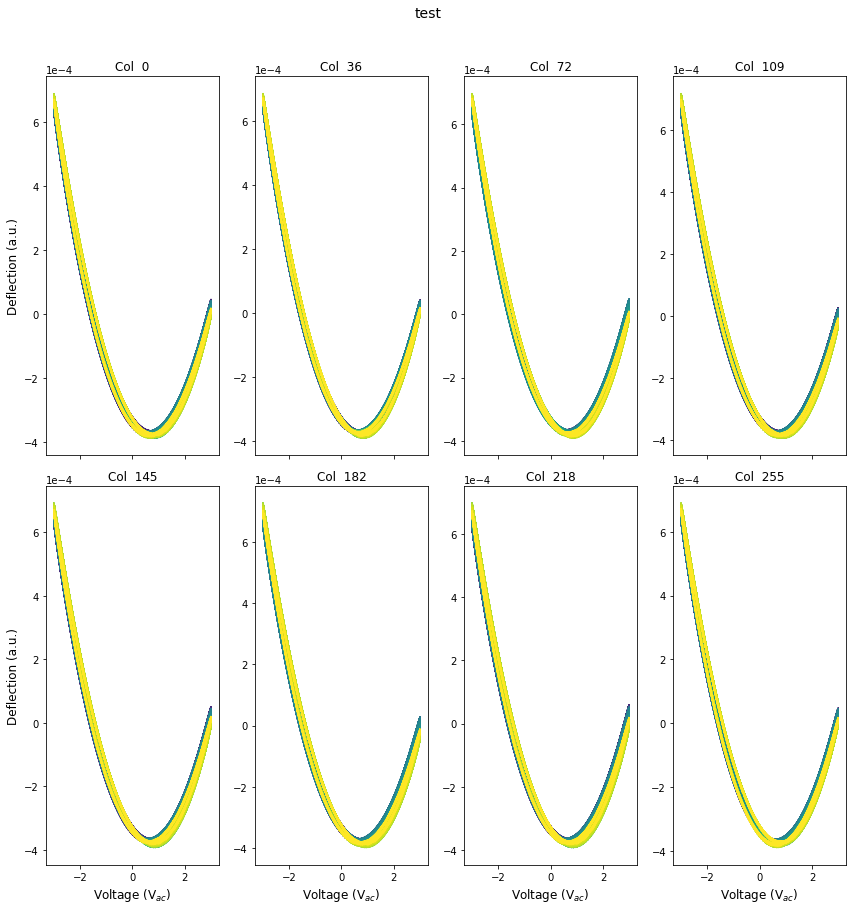

In [15]:
if DO_F3R:
    
    #########################################################################################################
    ### Function
    #########################################################################################################
    def scale_by_tune(filt_vec, w_vec, ph, ind_drive, TF_norm):
        tmp=np.fft.fftshift(np.fft.fft(filt_vec))
        signal_keep = np.argwhere(np.abs(tmp)>=Noiselimit).squeeze()
        tmp *= np.exp(-1j*w_vec/(w_vec[ind_drive])*ph)
        G[signal_keep]=tmp[signal_keep]
        G_time=np.real(np.fft.ifft(np.fft.ifftshift(G/TF_norm)))
        
        return G_time
    
  
    #########################################################################################################
    ### Perform F3R in parallel -- You should change n_jobs to match #cores you want to use 
    #########################################################################################################
    raw_data = h5_filt[()]
    scale_part = partial(scale_by_tune, w_vec=w_vec2, ph=ph, ind_drive=ind_drive, TF_norm=TF_norm)

    values = [joblib.delayed(scale_part)(filt_vec) for filt_vec in h5_filt]
    results = joblib.Parallel(n_jobs=num_cores)(values)

    G_time = np.array(results)

    del values, results
    
    #########################################################################################################
    ### Storing and Reshaping
    #########################################################################################################
    
    F3R_pos_vals=np.squeeze(h5_main.h5_pos_vals.value)
    F3R_pos_inds=h5_main.h5_pos_inds
    F3R_spec_vals = np.squeeze(h5_main.h5_spec_vals.value)
    F3R_spec_inds = h5_main.h5_spec_inds 

    F3R_pos_dim = px.hdf_utils.Dimension('Rows', 'um', F3R_pos_vals)
    F3R_spec_dim = px.hdf_utils.Dimension('Bias', 'V', F3R_spec_vals)

    F3R_grp = px.hdf_utils.create_indexed_group(h5_main.parent, 'F3R_Results')
    
    h5_F3R = px.hdf_utils.write_main_dataset(F3R_grp, G_time, 'F3R_data', 
                                           'Response', 'a.u.',
                                          F3R_pos_dim, F3R_spec_dim)
    hdf.file.flush()
    
elif not DO_F3R:   
    G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]

###################################
### Check a single row
###################################

raw=G_time[row_ind].reshape(-1,pixel_ex_wfm.size)


fig, axes = plot_curves(pixel_ex_wfm, raw, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                y_label='Deflection (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                title='test',use_rainbow_plots=True)

In [16]:
###################################
### Reshape Data
###################################

G_time = px.hdf_utils.find_dataset(hdf, 'F3R_data')[-1]
h5_resh_grp = px.core.hdf_utils.find_results_groups(G_time,'F3R_data')

if len(h5_resh_grp) > 0:
    print('Taking previously reshaped results')
    h5_resh_grp = h5_resh_grp[-1]
    h5_resh = px.hdf_utils.find_dataset(hdf,'Reshaped_Data')[0]
    
else:
    print('Reshape not performed on this dataset. Reshaping now:')
    scan_width = 1
    h5_resh = px.processing.gmode_utils.reshape_from_lines_to_pixels(h5_F3R, pixel_ex_wfm.size, scan_width / num_cols)
    h5_resh_grp = h5_resh.parent



px.hdf_utils.print_tree(hdf)

Taking previously reshaped results
/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ Rebuilt_Data_000
        ----------------
        ├ Rebuilt_Data
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
  ├ Channel_000
    -----------
    ├ F3R_Results_000
      ---------------
      ├ F3R_data
      ├ F3R_data-Reshape_000
        --------------------
        ├ Position_Indices
        ├ Position_Values
        ├ Reshaped_Data
        ├ Reshaped_Data-SVD_000
          ---------------------
          ├ Position_Indices
          ├ Position_Values
          ├ S
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
          ├ U
          ├ V
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Position_Indices



### Parabolic Fitting of Cleaned Data


In [17]:
###################################
### DO PCA (optional)
###################################


if Do_PCA2:
    do_svd = px.processing.svd_utils.SVD(h5_resh, num_components=256)
    h5_svd_group = do_svd.compute()

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    px.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_2.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]

    fig, axes = plot_curves(pixel_ex_wfm, first_evecs, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                    y_label='Displacement (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                    title='SVD Eigenvectors (F$^{3}$R)',use_rainbow_plots=True)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_2.tif', format='tiff')


    # Visualize the abundance maps:
    plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
         plt.savefig(output_filepath+'\PCARaw_Loading_2.tif', format='tiff')
     



### Test fitting on sample data

No handles with labels found to put in legend.


Text(0,0.5,'Displacement (a.u.)')

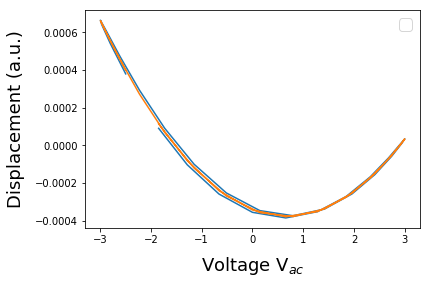

In [18]:
##########################################
### DO parabolic fitting of single point
##########################################

time_per_osc = 1/parms_dict['BE_center_frequency_[Hz]']
IO_rate = parms_dict['IO_rate_[Hz]']

N_points_per_pixel = parms_dict['num_bins']
pxl_time = N_points_per_pixel/IO_rate
num_periods = int(pxl_time // time_per_osc)
pnts_per_per = int(N_points_per_pixel // num_periods)
   
time = np.linspace(0,pxl_time,num_periods)
  
deg = 2

n = 2
m = 2
k4 = 22


resp = h5_resh[m][pnts_per_per*k4:pnts_per_per*(k4+1)]

resp = resp-np.mean(resp)
                  
V_per_osc = pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
p1,s = npPoly.polyfit(V_per_osc,resp,deg,full=True)
y1 = npPoly.polyval(V_per_osc,p1)

plt.figure()
plt.plot(V_per_osc, resp)
plt.plot(V_per_osc, y1)
plt.legend(fontsize=16)
plt.xlabel('Voltage V$_{ac}$', fontsize=18, labelpad=10)
plt.ylabel('Displacement (a.u.)', fontsize=18, labelpad=10)

## Repeat on the full dataset

In [29]:
if do_para_fit:

    def fit_cleaned(data_vec, pixel_ex_wfm, pnts_per_per, num_periods, deg):
        fit = np.zeros([num_periods, deg+1])
        for k4 in range(num_periods):#osc_period
            resp=data_vec[pnts_per_per*k4:pnts_per_per*(k4+1)]
            resp=resp-np.mean(resp)
            V_per_osc=pixel_ex_wfm[pnts_per_per*k4:pnts_per_per*(k4+1)]
            p1,s=npPoly.polyfit(V_per_osc,resp,deg,full=True)
            y1=npPoly.polyval(V_per_osc,p1)           

            fit[k4,:]=p1
        return fit

    part_fit_func = partial(fit_cleaned, pixel_ex_wfm=pixel_ex_wfm, pnts_per_per=pnts_per_per, num_periods=num_periods, deg=deg)

   

    values = [joblib.delayed(part_fit_func)(data) for data in h5_resh]
    #change n_jobs below as approraite to the number of cores you want to use
    results = joblib.Parallel(n_jobs=num_cores)(values)

    wHfit3 = np.array(results)

    CPD=-0.5*np.divide(wHfit3[:,:,1],wHfit3[:,:,0]) 

    del values, results
    
    ##########################################
    ### Save CPD to HD5 (need to change to save all fit)
    ##########################################
    
        
    CPD_pos_vals=np.arange(0,num_rows*num_cols)
    CPD_spec_vals = time 

    CPD_pos_dim = px.hdf_utils.Dimension('Rows', 'um', CPD_pos_vals)
    CPD_spec_dim = px.hdf_utils.Dimension('Time', 'S', CPD_spec_vals)

    CPD_grp = px.hdf_utils.create_indexed_group(h5_main.parent.parent, 'CPD')
    
    h5_CPD = px.hdf_utils.write_main_dataset(CPD_grp, CPD, 'CPD', 
                                           'CPD', 'V',
                                          pos_dims, CPD_spec_dim)
    
    hdf.file.flush()
    
elif not do_para_fit:
  px.hdf_utils.print_tree(hdf)
  h5_CPD = px.hdf_utils.find_dataset(hdf,'CPD')[-1]
 

/
├ Measurement_000
  ---------------
  ├ CPD_000
    -------
    ├ CPD
    ├ CPD-SVD_000
      -----------
      ├ Position_Indices
      ├ Position_Values
      ├ Rebuilt_Data_000
        ----------------
        ├ Rebuilt_Data
      ├ S
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ U
      ├ V
    ├ Position_Indices
    ├ Position_Values
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
  ├ Channel_000
    -----------
    ├ F3R_Results_000
      ---------------
      ├ F3R_data
      ├ F3R_data-Reshape_000
        --------------------
        ├ Position_Indices
        ├ Position_Values
        ├ Reshaped_Data
        ├ Reshaped_Data-SVD_000
          ---------------------
          ├ Position_Indices
          ├ Position_Values
          ├ S
          ├ Spectroscopic_Indices
          ├ Spectroscopic_Values
          ├ U
          ├ V
        ├ Spectroscopic_Indices
        ├ Spectroscopic_Values
      ├ Position_Indices
      ├ Position_Values
      ├ Spe

## Data Visualization 
#### Plot single point

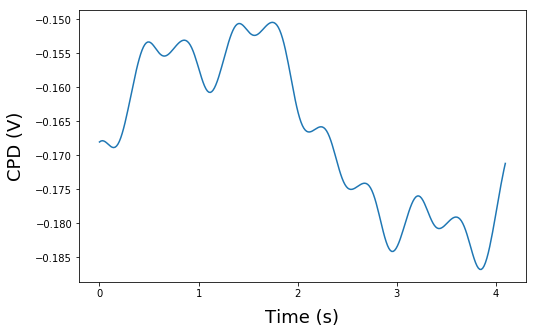

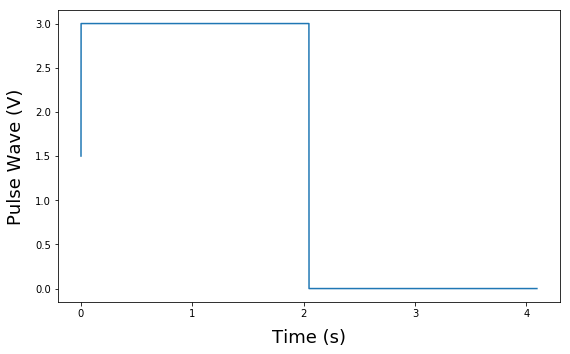

In [30]:
##########################################
### Plot Single Point
##########################################

test=CPD[100,:]
time=np.linspace(0.0,pxl_time,num_periods)

plt.figure(1, figsize=(8,5))
plt.plot(time*1000,test)
plt.xlabel('Time (s)', fontsize=18, labelpad=10)
plt.ylabel('CPD (V)', fontsize=18, labelpad=10)


plt.figure(2, figsize=(8,5))
plt.plot(t_vec_pix,pulse_wave)
plt.xlabel('Time (s)', fontsize=18, labelpad=10)
plt.ylabel('Pulse Wave (V)', fontsize=18, labelpad=10)

if save_figure == True:
    plt.savefig(output_filepath+'\CPD_vs_time.tif', format='tiff')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.
[<HDF5 group "/Measurement_000/CPD_000/CPD-SVD_000" (9 members)>]
Took 3.3 sec to compute randomized SVD


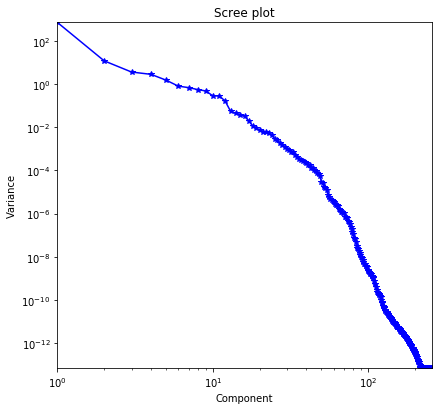

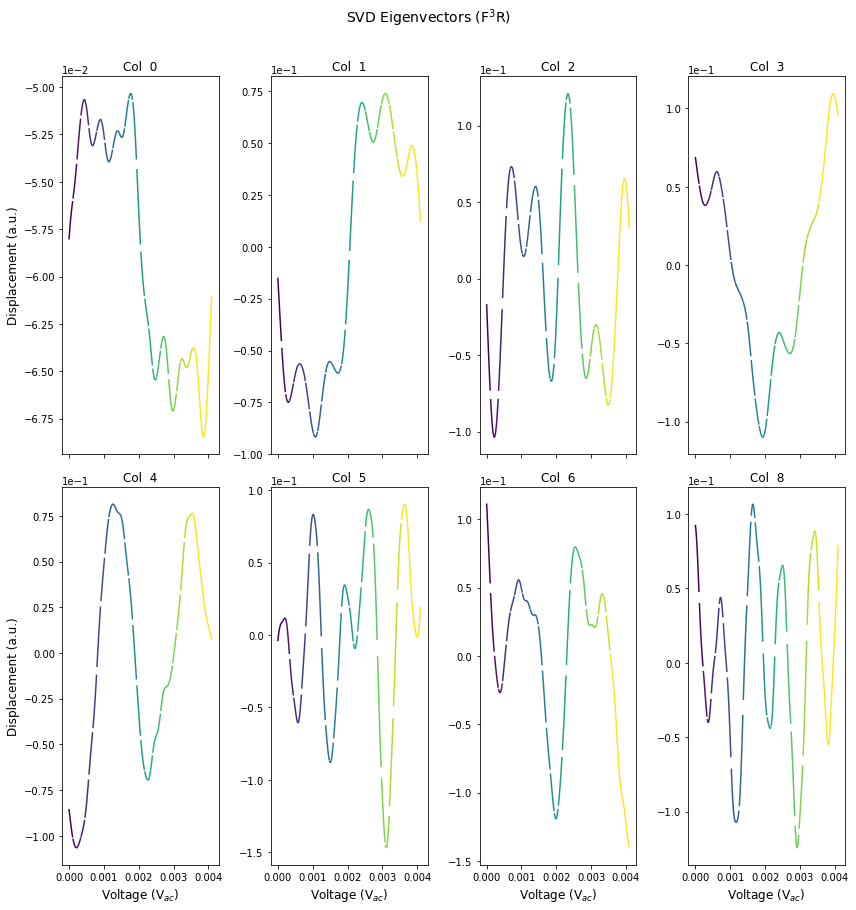

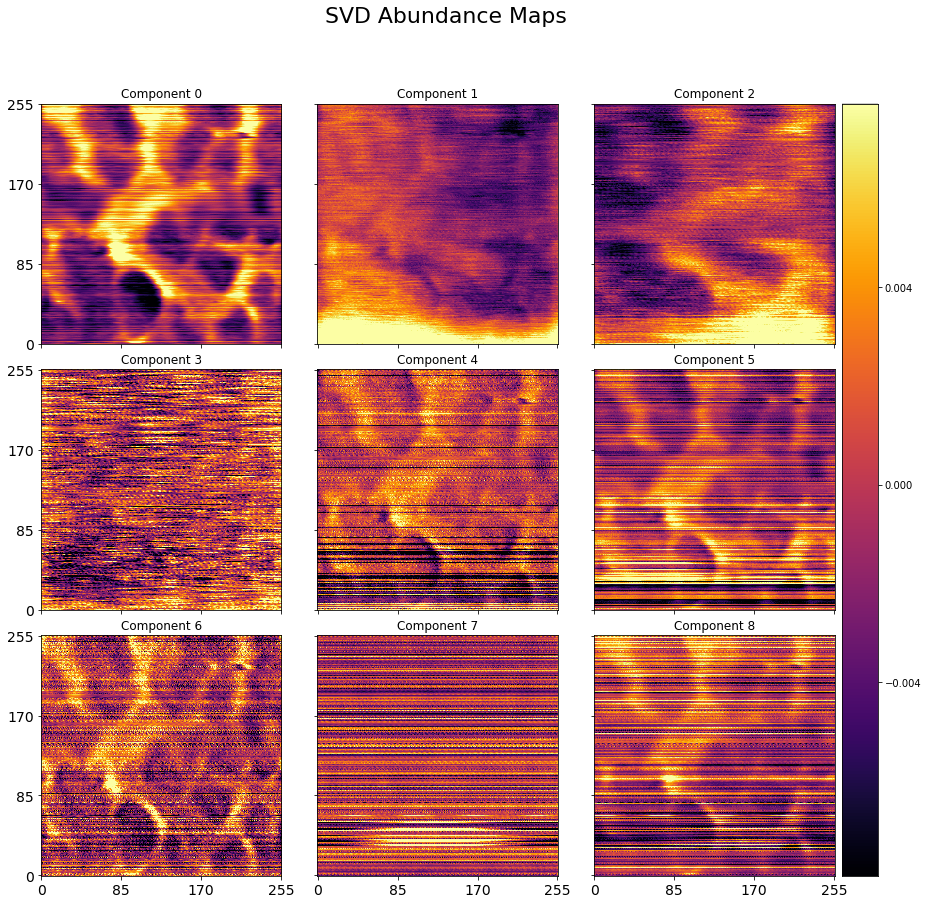

In [33]:
do_PCA_CPD=True
if do_PCA_CPD: #
    ##########################################
    ### DO PCA of CPD results
    ##########################################

    do_svd = px.processing.svd_utils.SVD(h5_CPD, num_components=256)
    h5_svd_group = do_svd.compute(override=True)

    h5_u = h5_svd_group['U']
    h5_v = h5_svd_group['V']
    h5_s = h5_svd_group['S']

    # Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
    abun_maps = np.reshape(h5_u[:,:25], (num_rows, num_cols,-1))

    # Visualize the variance / statistical importance of each component:
    px.plot_utils.plot_scree(h5_s, title='Scree plot')

    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Scree_CPD.tif', format='tiff')


    # Visualize the eigenvectors:
    first_evecs = h5_v[:9, :]

    fig, axes = plot_curves(time, first_evecs, line_colors=['r'], x_label='Voltage (V$_{ac}$)',
                                                    y_label='Displacement (a.u.)', subtitle_prefix='Col ', num_plots=8,
                                                    title='SVD Eigenvectors (F$^{3}$R)',use_rainbow_plots=True)


    if save_figure == True:
        plt.savefig(output_filepath+'\PCARaw_Eig_CPD.tif', format='tiff')


    # Visualize the abundance maps:
    plot_map_stack(abun_maps, num_comps=9, title='SVD Abundance Maps', reverse_dims=True,
                                 color_bar_mode='single', cmap='inferno', title_yoffset=0.95)


    if save_figure == True:
    #     fig.savefig(output_filepath+'\PCARaw_Loading.eps', format='eps')
    #     fig.savefig(output_filepath+'\PCARaw_Loading.tif', format='tiff')
        plt.savefig(output_filepath+'\PCARaw_Loading_CPD.tif', format='tiff')
        #save_figure = False;


In [32]:
# important! If choosing components, min is 3 or interprets as start/stop range of slice
clean_components = np.array([1,2]) # np.append(range(5,9),(17,18))
#num_components=len(clean_components)

test=px.processing.svd_utils.rebuild_svd(h5_CPD, components=256)
PCAcleandata=test[:,:].reshape(num_rows,-1)
PCAcleandata.shape
# Since the two spatial dimensions (x, y) have been collapsed to one, we need to reshape the abundance maps:
PCAcleandata = np.reshape(PCAcleandata, (num_rows*num_cols,-1))
CPD=PCAcleandata

Reconstructing in batches of 1568 positions.
Batchs should be 880.46875 Mb each.
Completed reconstruction of data from SVD results.  Writing to file.
Done writing reconstructed data to file.
